In [1]:
import numpy
import matplotlib.pyplot as plt
from scipy import integrate

https://stackoverflow.com/questions/78365494/solving-coupled-odes-in-python-too-much-little-oscillation

In [12]:
kp = 0.07                 # M^-1 s^-1
kr = 6                    # s^-1
ks = 1e-6                 # s^-1
kds = 1e-5
kdns = 1/600.             # s^-1
ATP = 7.2e-3              # M
w0 = 1e6                  # s^-1
kb = 1.3806452e-23        # J/K
T = 310                   # K
u0 = 1e-9                 # m
umax = 28e-9              # m
delta_G = 35 * kb * T     # J
ntitin = 4.7e-6           # M 

In [13]:
@numpy.vectorize
def force_input(t):
    high_force = 20e-12
    low_force = 4.5e-12
    
    on_off_period = 20
    full_set_period = 260
    
    position_in_set = t % full_set_period
    
    if t < 0.:
        return low_force
    if position_in_set > 10 * on_off_period:
        return low_force
    else:
        position_in_on_off = position_in_set % on_off_period
        return high_force if position_in_on_off < 10. else low_force

In [14]:
def equations(t, y):
    
    nc, no, np, ns = y
    
    # Calculate ns using the constraint
    #ns = ntitin - (no + nc + np)
    
    f = force_input(t)
    Eplus = delta_G - f * u0
    Eminus = f * (umax - u0)
    
    kplus = w0 * numpy.exp((-Eplus) / (kb * T))
    kminus = w0 * numpy.exp((-Eminus) / (kb * T))
    
    dnc_dt = -kplus * nc + kminus * no
    dno_dt = kplus * nc - kminus * no - kp * no * ATP + kr * np + kdns * ns
    dnp_dt = kp * no * ATP - kr * np - ks * np
    dns_dt = kdns * ns - kds * np

    return [dnc_dt, dno_dt, dnp_dt, dns_dt]

no0 = 0.0006 * ntitin
np0 = 0.0025 * ntitin
ns0 = 1e-12
nc0 = ntitin - no0 - np0 - ns0 
y0 = [nc0, no0, np0, ns0]

t_span = [-1., 0.5 * 260.]
t_values = numpy.linspace(t_span[0], t_span[1], 10000)

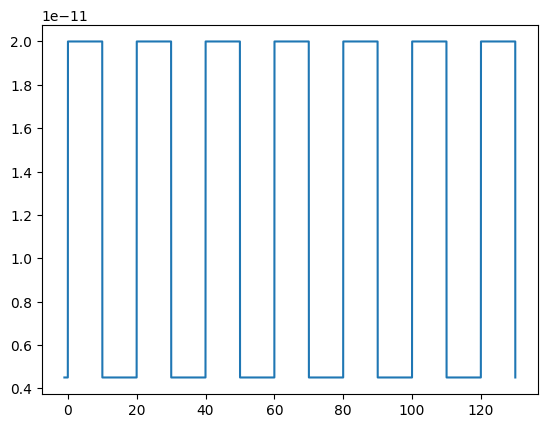

In [15]:
fig, axe = plt.subplots()
axe.plot(t_values, force_input(t_values))

In [16]:
solution = integrate.solve_ivp(equations, t_span, y0, t_eval=t_values, atol=1e-18)
solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [-1.000e+00 -9.869e-01 ...  1.300e+02  1.300e+02]
        y: [[ 4.685e-06  4.685e-06 ...  4.685e-06  4.685e-06]
            [ 2.820e-09  3.708e-09 ...  1.459e-08  1.459e-08]
            [ 1.175e-08  1.086e-08 ...  1.226e-12  1.226e-12]
            [ 1.000e-12  9.985e-13 ...  1.218e-12  1.218e-12]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1712
     njev: 0
      nlu: 0

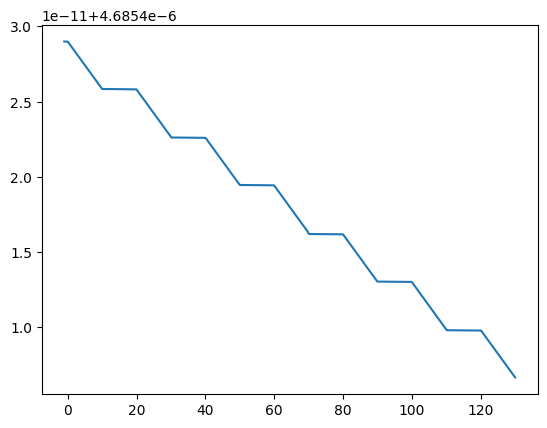

In [17]:
fig, axe = plt.subplots()
axe.plot(t_values, solution.y[0])

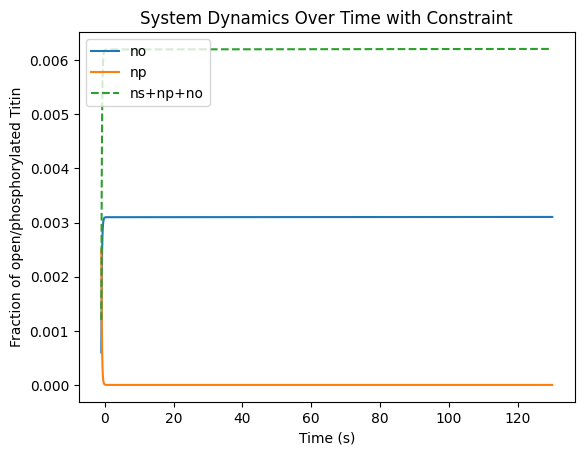

In [18]:

# Calculate ns for each time point using the constraint
ns_values = ntitin - (solution.y[0] + solution.y[1] + solution.y[2])
sum_values = (ns_values + solution.y[1] + solution.y[1])/ntitin

# Plotting the results
#plt.plot(solution.t, solution.y[0]/ntitin, label='nc')
plt.plot(solution.t, solution.y[1]/ntitin, label='no')
plt.plot(solution.t, solution.y[2]/ntitin, label='np')
plt.plot(solution.t, sum_values, label='ns+np+no', linestyle='--')  # Dashed line for ns
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Fraction of open/phosphorylated Titin')
plt.title('System Dynamics Over Time with Constraint')
plt.show()